## A/B Testing for Sales Conversion

### 1. Import package and load data

In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from statsmodels.stats import power as pwr
from statsmodels.stats.proportion import proportion_confint
from sklearn.impute import KNNImputer
import statsmodels.stats.api as sms

sys.path.append("../src")
import process, abtest

In [2]:
df = pd.read_csv("../data/raw/KAG_conversion_data.csv")
df.head()

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,impressions,clicks,spent,total_conversion,approved_conversion
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0
3,708815,916,103928,30-34,M,28,4259,1,1.25,1,0
4,708818,916,103928,30-34,M,28,4133,1,1.29,1,1


In [3]:
process.data_overview(df)

1. Shape of dataset: (1143, 11)
2. Columns datatype: 
int64	| ad_id, xyz_campaign_id, fb_campaign_id, interest, impressions, clicks, total_conversion, approved_conversion, 
float64	| spent, 
object	| age, gender, 


### 2. Clean data

In [4]:
print("The number of 0-values in clicks (given conversion are non-zero):", len(df[(df["clicks"] == 0) & (df["total_conversion"] != 0)]))
df["clicks"].replace(0, np.nan, inplace=True)

imputer = KNNImputer(n_neighbors=2)
df_imputed = pd.DataFrame(imputer.fit_transform(df.drop(columns=["gender", "age"])))

df["clicks"] = df_imputed[5]

The number of 0-values in clicks (given conversion are non-zero): 204


In [5]:
df['xyz_campaign_id'] = df['xyz_campaign_id'].astype('str')
df['xyz_campaign_id'].unique()

array(['916', '936', '1178'], dtype=object)

In [6]:
df.drop(['ad_id', 'fb_campaign_id'], axis='columns', inplace=True)
df['CPC']=df['spent']/df['clicks']
df['CTR']=df['clicks']/df['impressions']
# df['converted']=df['Total_Conversion']/df['Impressions']

In [7]:
process.check_missing_data(df)

xyz_campaign_id        0.0
age                    0.0
gender                 0.0
interest               0.0
impressions            0.0
clicks                 0.0
spent                  0.0
total_conversion       0.0
approved_conversion    0.0
CPC                    0.0
CTR                    0.0
dtype: float64

#### 3. Treatment and control group & guardrail check

In [8]:
df_control = df.loc[df['xyz_campaign_id']=='1178']
df_test = df[df['xyz_campaign_id']=='936']
cont_size = len(df_control['xyz_campaign_id'])
test_size = len(df_test['xyz_campaign_id'])
n = len(df)

In [9]:
ctr_control = df_control["clicks"].sum() / df_control["impressions"].sum()
ctr_test = df_test["clicks"].sum() / df_test["impressions"].sum()
print(f'Click through rate:\n\tControl group: {ctr_control:.6f}')
print(f'\tTreatment group: {ctr_test:.6f}')

Click through rate:
	Control group: 0.000176
	Treatment group: 0.000268


In [10]:
# Guardrail Check on differences in proportions:
(lower_i, upper_i) = proportion_confint(n/2, n, .05)
print(f'Does the control group proportion {cont_size/n:.3f} lie within ({lower_i:.3f}, {upper_i:.3f})?')

Does the control group proportion 0.547 lie within (0.471, 0.529)?


We've calculated 95% confidence intervals for our $\widehat{p_{control}}$ does not lie within the CI. This means that we've failed our Guardrail Metric. The number of unique users is not equal for each group.

### 4. Sample size & minimum detectable effect size

In [11]:
# Firstly, define the two conversion rates via proportion_effectsize. The first element is the base rate prior to running the test,
# the second one is the minimum conversion rate of the test that would make it worth it to make the change
p1_and_p2 = sms.proportion_effectsize(ctr_control, ctr_control+0.01)

sample_size = sms.NormalIndPower().solve_power(p1_and_p2, power=0.8, alpha=0.05)
print("The required sample size per group is ~", round(sample_size))

The required sample size per group is ~ 509


To detect a rise of at least 1% in click-through rate, a total of 509 data points are required for each test and control groups. 

The graph provided below demonstrates how the sample size would vary with different minimum conversion rate values, aimed at achieving this change.

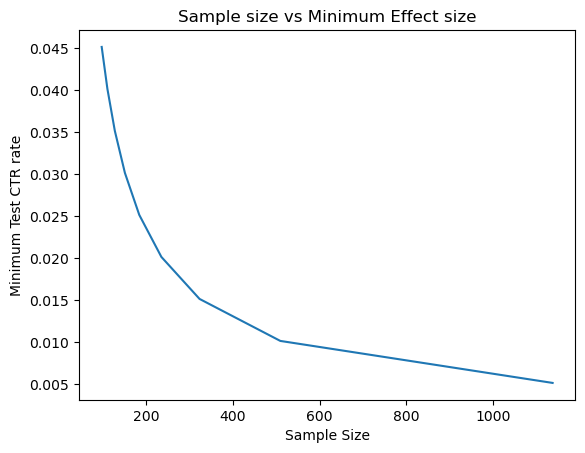

In [12]:
possible_p2 = np.arange(ctr_control+0.005, ctr_control+0.05, .005)  # possible p2 values with 0.5% increments

# estimate sample size & plot
sample_size = []
for i in possible_p2:
   p1_and_p2 = sms.proportion_effectsize(ctr_control, i)
   sample_size.append(sms.NormalIndPower().solve_power(p1_and_p2, power=0.8, alpha=0.05))
plt.plot(sample_size, possible_p2)
plt.title("Sample size vs Minimum Effect size")
plt.xlabel("Sample Size")
plt.ylabel("Minimum Test CTR rate")
plt.show()

### 5. Proportional Z test & confidence interval

In [13]:
#returning the total number of conversions for each group:
alpha=0.05
clicks = np.array([df_control["clicks"].sum(), df_test["clicks"].sum()])
impressions = np.array([df_control["impressions"].sum(), df_test["impressions"].sum()])
        
abtest.ztest(clicks, impressions, "smaller")
print('-------------------')
abtest.conf_int(clicks, impressions)

H0: CTR for control > treatment
H1: CTR for control < treatment.

Z test statistic is -19.071
p-value for Z test is 0.000

p-value = 0.000 < 0.05
We can reject null hypothesis. CTR in treatment group is larger
-------------------
ci 95% for control group: [0.000174, 0.000178]
ci 95% for treatment group: [0.000256, 0.000279]


### 6. Cost per click

In [14]:
print(f'Cost per click (mean):\n \t Control group: {df_control["CPC"].mean():.6f}')
print(f'\t Treatment group: {df_test["CPC"].mean():.6f}')

print('-------------------')

abtest.hypothesis_test(df_control, df_test, 'CPC')

Cost per click (mean):
 	 Control group: 1.542302
	 Treatment group: 0.846742
-------------------
Control group: Shapiro Test Stat = 0.7064, p-value = 0.0000
Treatment group: Shapiro Test Stat = 0.7840, p-value = 0.0000
Levene Test Stat = 454.0077, p-value = 0.0000
H0: CTR for control = treatment
H1: CTR for control != treatment.

Mannwhitneye Test Stat = 239584.0000, p-value = 0.0000
H0 hypothesis REJECTED


### 7. Bootstrapping

100.0%


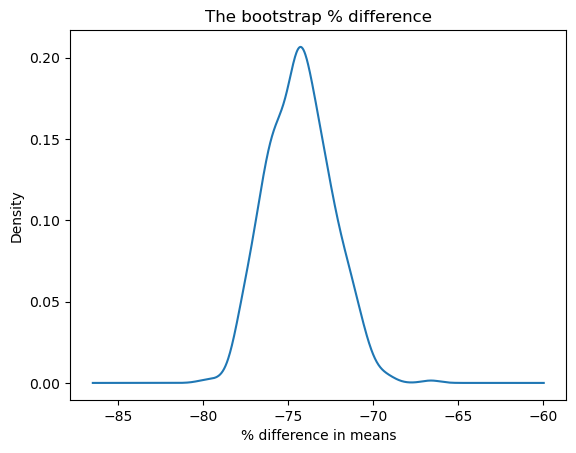

In [15]:
# create a list with bootstrapped means for each group
boot_df = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('xyz_campaign_id')['CTR'].mean()
    boot_df.append(boot_mean)
    
boot_df = pd.DataFrame(boot_df, columns=['1178', '936'])  # transform the list to a DataFrame
boot_df['diff'] = ((boot_df['1178'] - boot_df['936'])/boot_df['936']) * 100  # add a column with % difference between two groups
ax = boot_df['diff'].plot(kind='kde')  # plot the bootstrap % difference
ax.set_title("The bootstrap % difference")
ax.set_xlabel("% difference in means")

prob = (boot_df['diff'] < -0.62).mean()  # calculate the probability that control mean is smaller than treatment mean
print(f'{prob:.1%}')  # print the probability

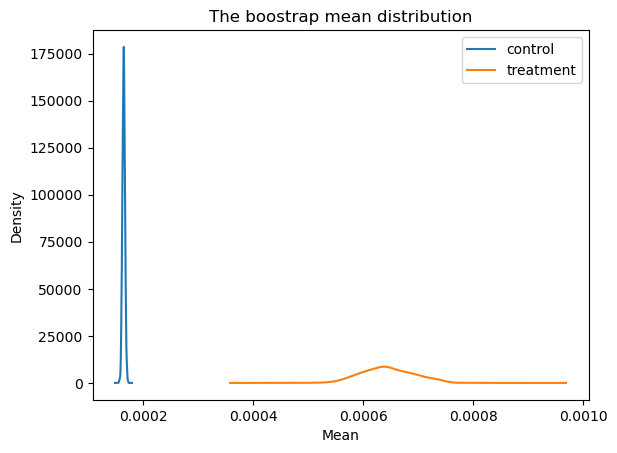

In [16]:
# plot of the bootstrap distributions
ax = boot_df[['1178', '936']].plot(kind = 'kde')
ax.set_xlabel('Mean')
ax.set_title("The boostrap mean distribution")
ax.legend(['control', 'treatment'])
plt.show()